In [1]:
import Utilities.prelude as prel
import numpy as np
import matplotlib.pyplot as plt

from src.shock_zone import shock_direction, find_prepost
from Utilities.operators import make_tree, calc_grad

In [2]:
z_chosen = 0
mach_min = 1.3
gamma = 5/3
save = True
folder = 'sedov'
snap = '100'
path = f'{folder}/{snap}'

if folder == 'TDE':
    is_tde = True
    epsilon = 2
else:
    is_tde = False
    epsilon = 0.02

In [20]:
def soundspeed(gamma, pressure, density):
    cs = np.sqrt(gamma*pressure/density)
    return cs

def surface_area(volume):
    surf = volume**(2/3)
    return surf

def density_bump(mach):
    """ rho_post/ rho_pre shock"""
    rhobump = (gamma+1) * mach**2 / ((gamma-1)*mach**2 + 2)
    return rhobump

def kinetic_enflux(den_pre, cs_pre, mach):
    f_phi = 0.5 * den_pre * (cs_pre * mach)**3
    return f_phi

def efficiency(mach):
    # Eq.(8) from Schaal14
    R = density_bump(mach)
    delta = 2 / (gamma * (gamma-1) * mach**2 * R) * ((2*gamma*mach**2-(gamma-1)/(gamma+1)) - R**gamma)
    return delta

def energy_flux(den_pre, cs_pre, mach):
    # Eq.(7) from Schaal14
    delta = efficiency(mach)
    f_phi = kinetic_enflux(den_pre, cs_pre, mach)
    f_th = delta * f_phi
    return f_th

def analytical_flux(idx_pre, idx_post, en_density, density, velocity, temperature, volume):
    # e_pre = en_density[idx_pre]
    e_pre = prel.Kb * temperature[idx_pre] / volume[idx_pre]
    den_pre = density[idx_pre]
    # e_post = en_density[idx_post]
    e_post = prel.Kb *  temperature[idx_post] / volume[idx_post]
    den_post = density[idx_post]
    vel_post =  velocity[idx_post]
    f_analytical = (e_post - e_pre * (den_post/den_pre)**gamma) * vel_post
    return  f_analytical

In [21]:
sim_tree, X, Y, Z, Vol, VX, VY, VZ, IE, Den, Press, Temp = make_tree(path, snap, is_tde, int_energy = True)
V = np.sqrt(VX**2 + VY**2 + VZ**2)

all T=0, bro. Compute by myself!


In [22]:
# Import data
shockzone = np.loadtxt(f'data/{snap}/shockzone_{snap}.txt')
shocksurface = np.loadtxt(f'data/{snap}/shocksurface_{snap}.txt')

x_zone = shockzone[0]
y_zone = shockzone[1]
z_zone = shockzone[2]
idx_zone = shockzone[5]

idx_surf = shocksurface[0]
mach_shock = shocksurface[1]
indeces_pre = shocksurface[4]
indeces_post = shocksurface[5]

In [23]:
idx_zone = [int(i) for i in idx_zone]
vol_zone = Vol[idx_zone]

In [24]:
idx_surf = [int(i) for i in idx_surf]
x_surf = x_zone[idx_surf]
y_surf = y_zone[idx_surf]
z_surf = z_zone[idx_surf]
vol_surface = vol_zone[idx_surf]

In [25]:
flux = np.zeros(len(x_surf))
an_flux = np.zeros(len(x_surf))

for i in range(len(x_surf)):
    surf = surface_area(vol_surface[i])
    mach = mach_shock[i]
    idx_pre = int(indeces_pre[i])
    idx_post = int(indeces_post[i])
    cs_pre = soundspeed(gamma, Press[idx_pre], Den[idx_pre])
    f_th = energy_flux(Den[idx_pre], cs_pre, mach)
    flux[i] = f_th
    f_an = analytical_flux(idx_pre, idx_post, IE, Den, V, Temp, Vol)
    an_flux[i] = f_an
    

In [26]:
surface_cross_x = x_surf[np.abs(z_surf-z_chosen)<epsilon]
surface_cross_y = y_surf[np.abs(z_surf-z_chosen)<epsilon]
flux_cross = flux[np.abs(z_surf-z_chosen)<epsilon]
an_flux_cross = an_flux[np.abs(z_surf-z_chosen)<epsilon]

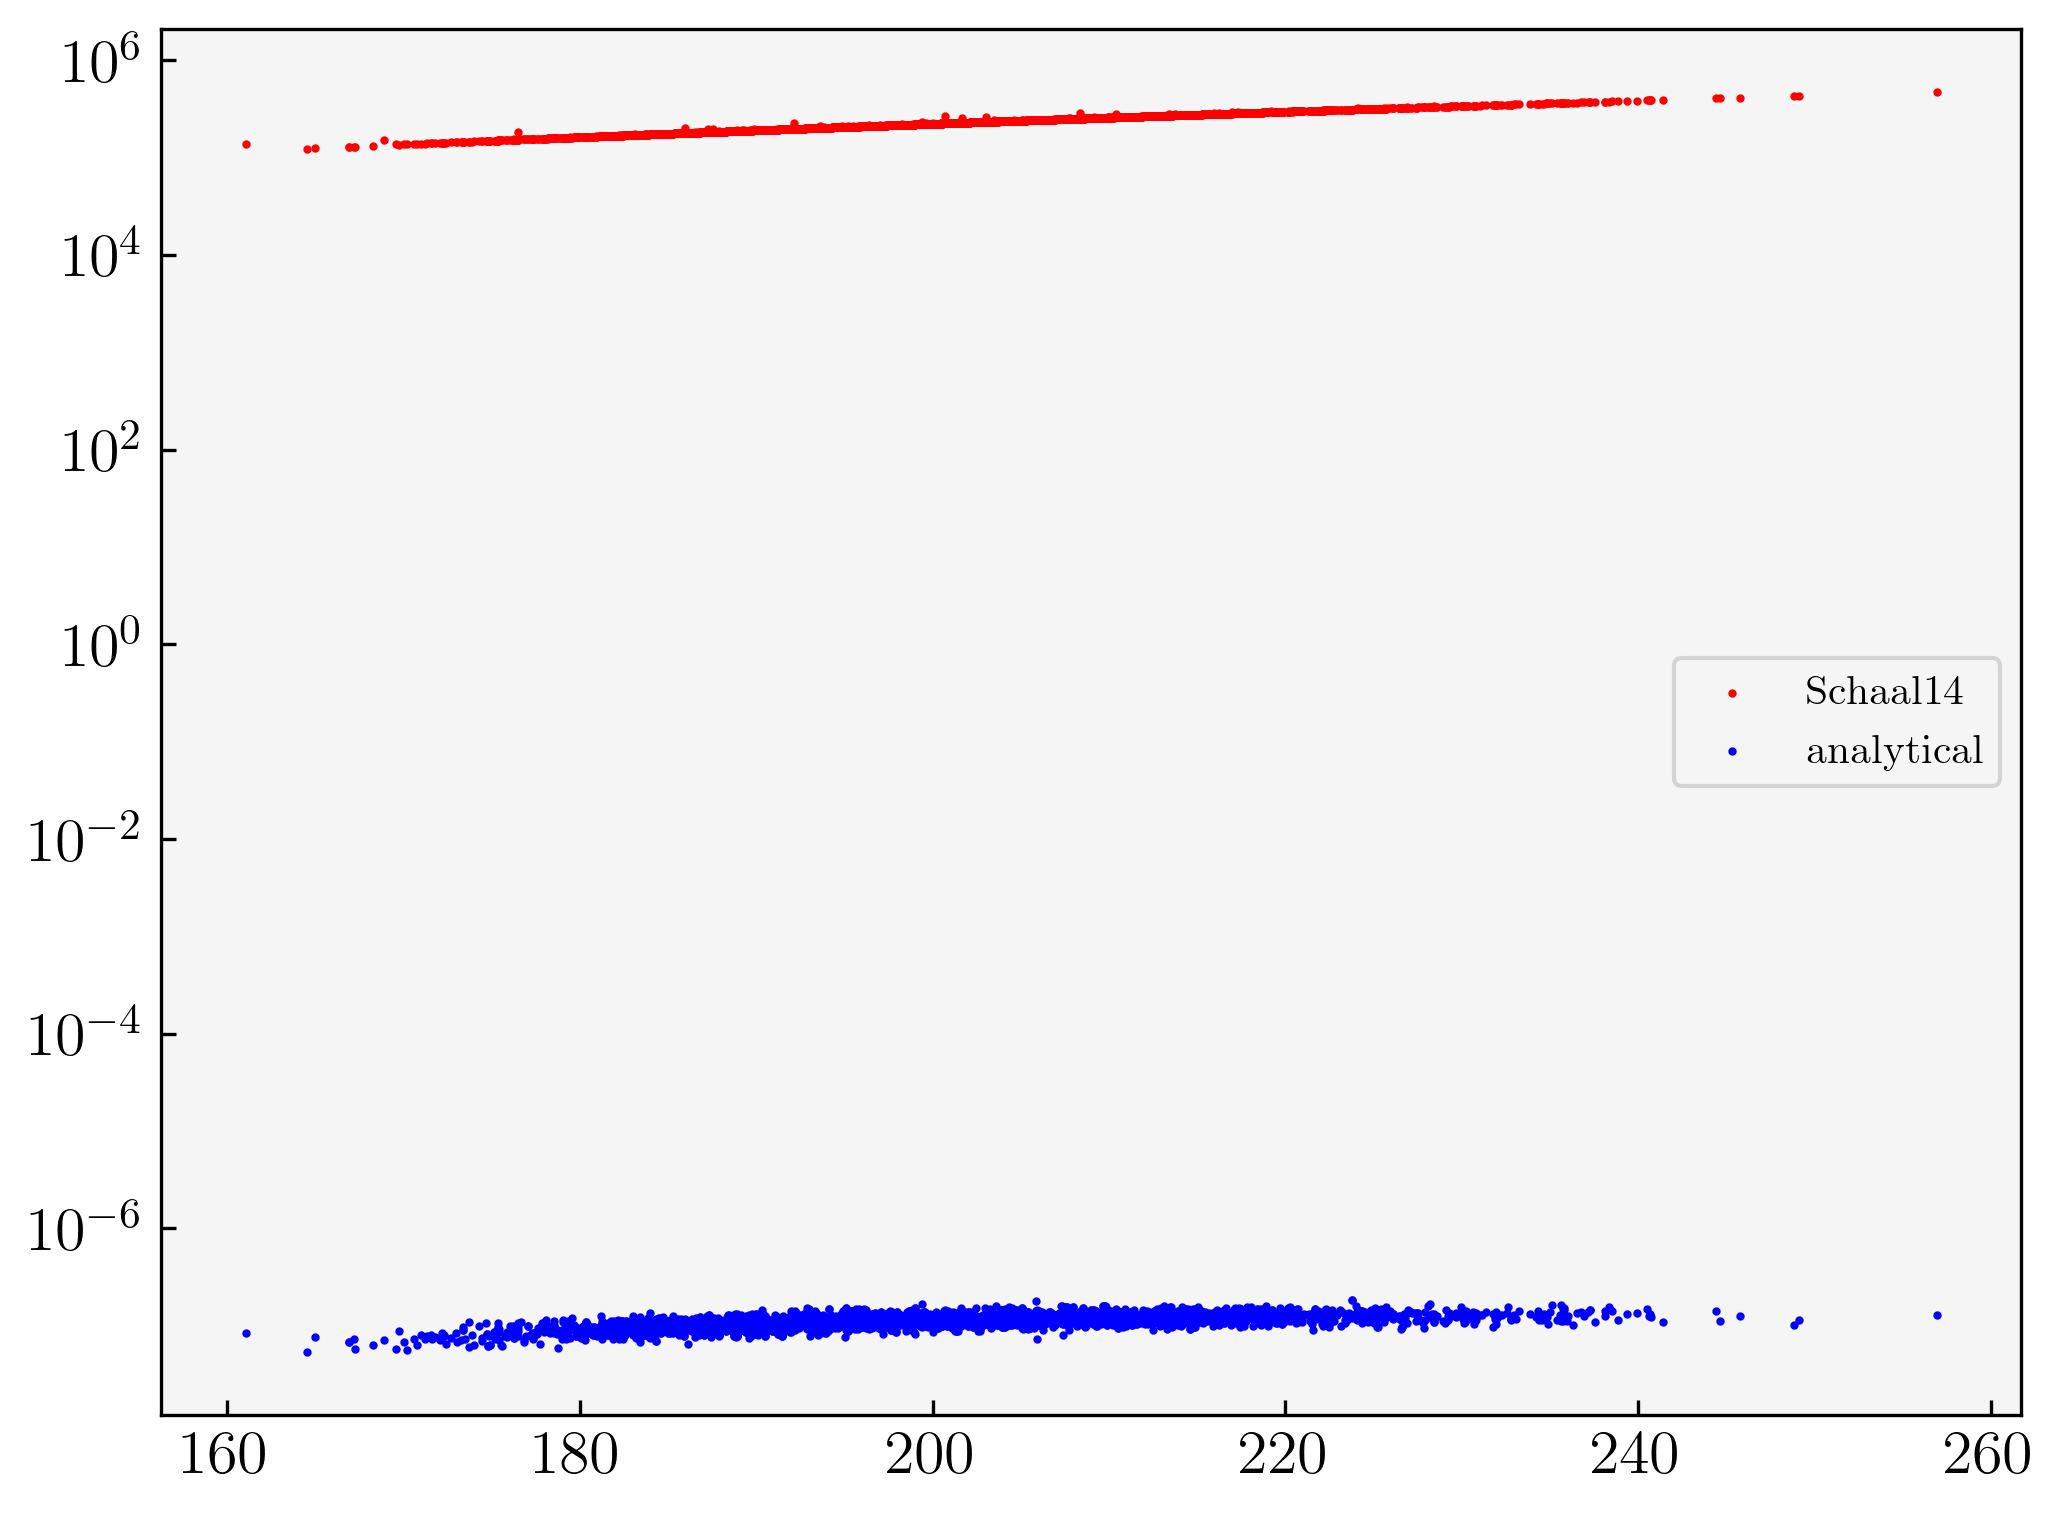

In [27]:
plt.scatter(mach_shock, flux, c = 'r', s=1, label = 'Schaal14')
plt.scatter(mach_shock, an_flux, c = 'b', s=1, label = 'analytical')
plt.yscale('log')
plt.legend()

Text(0.5, 1.0, 'Energy flux, z = 0')

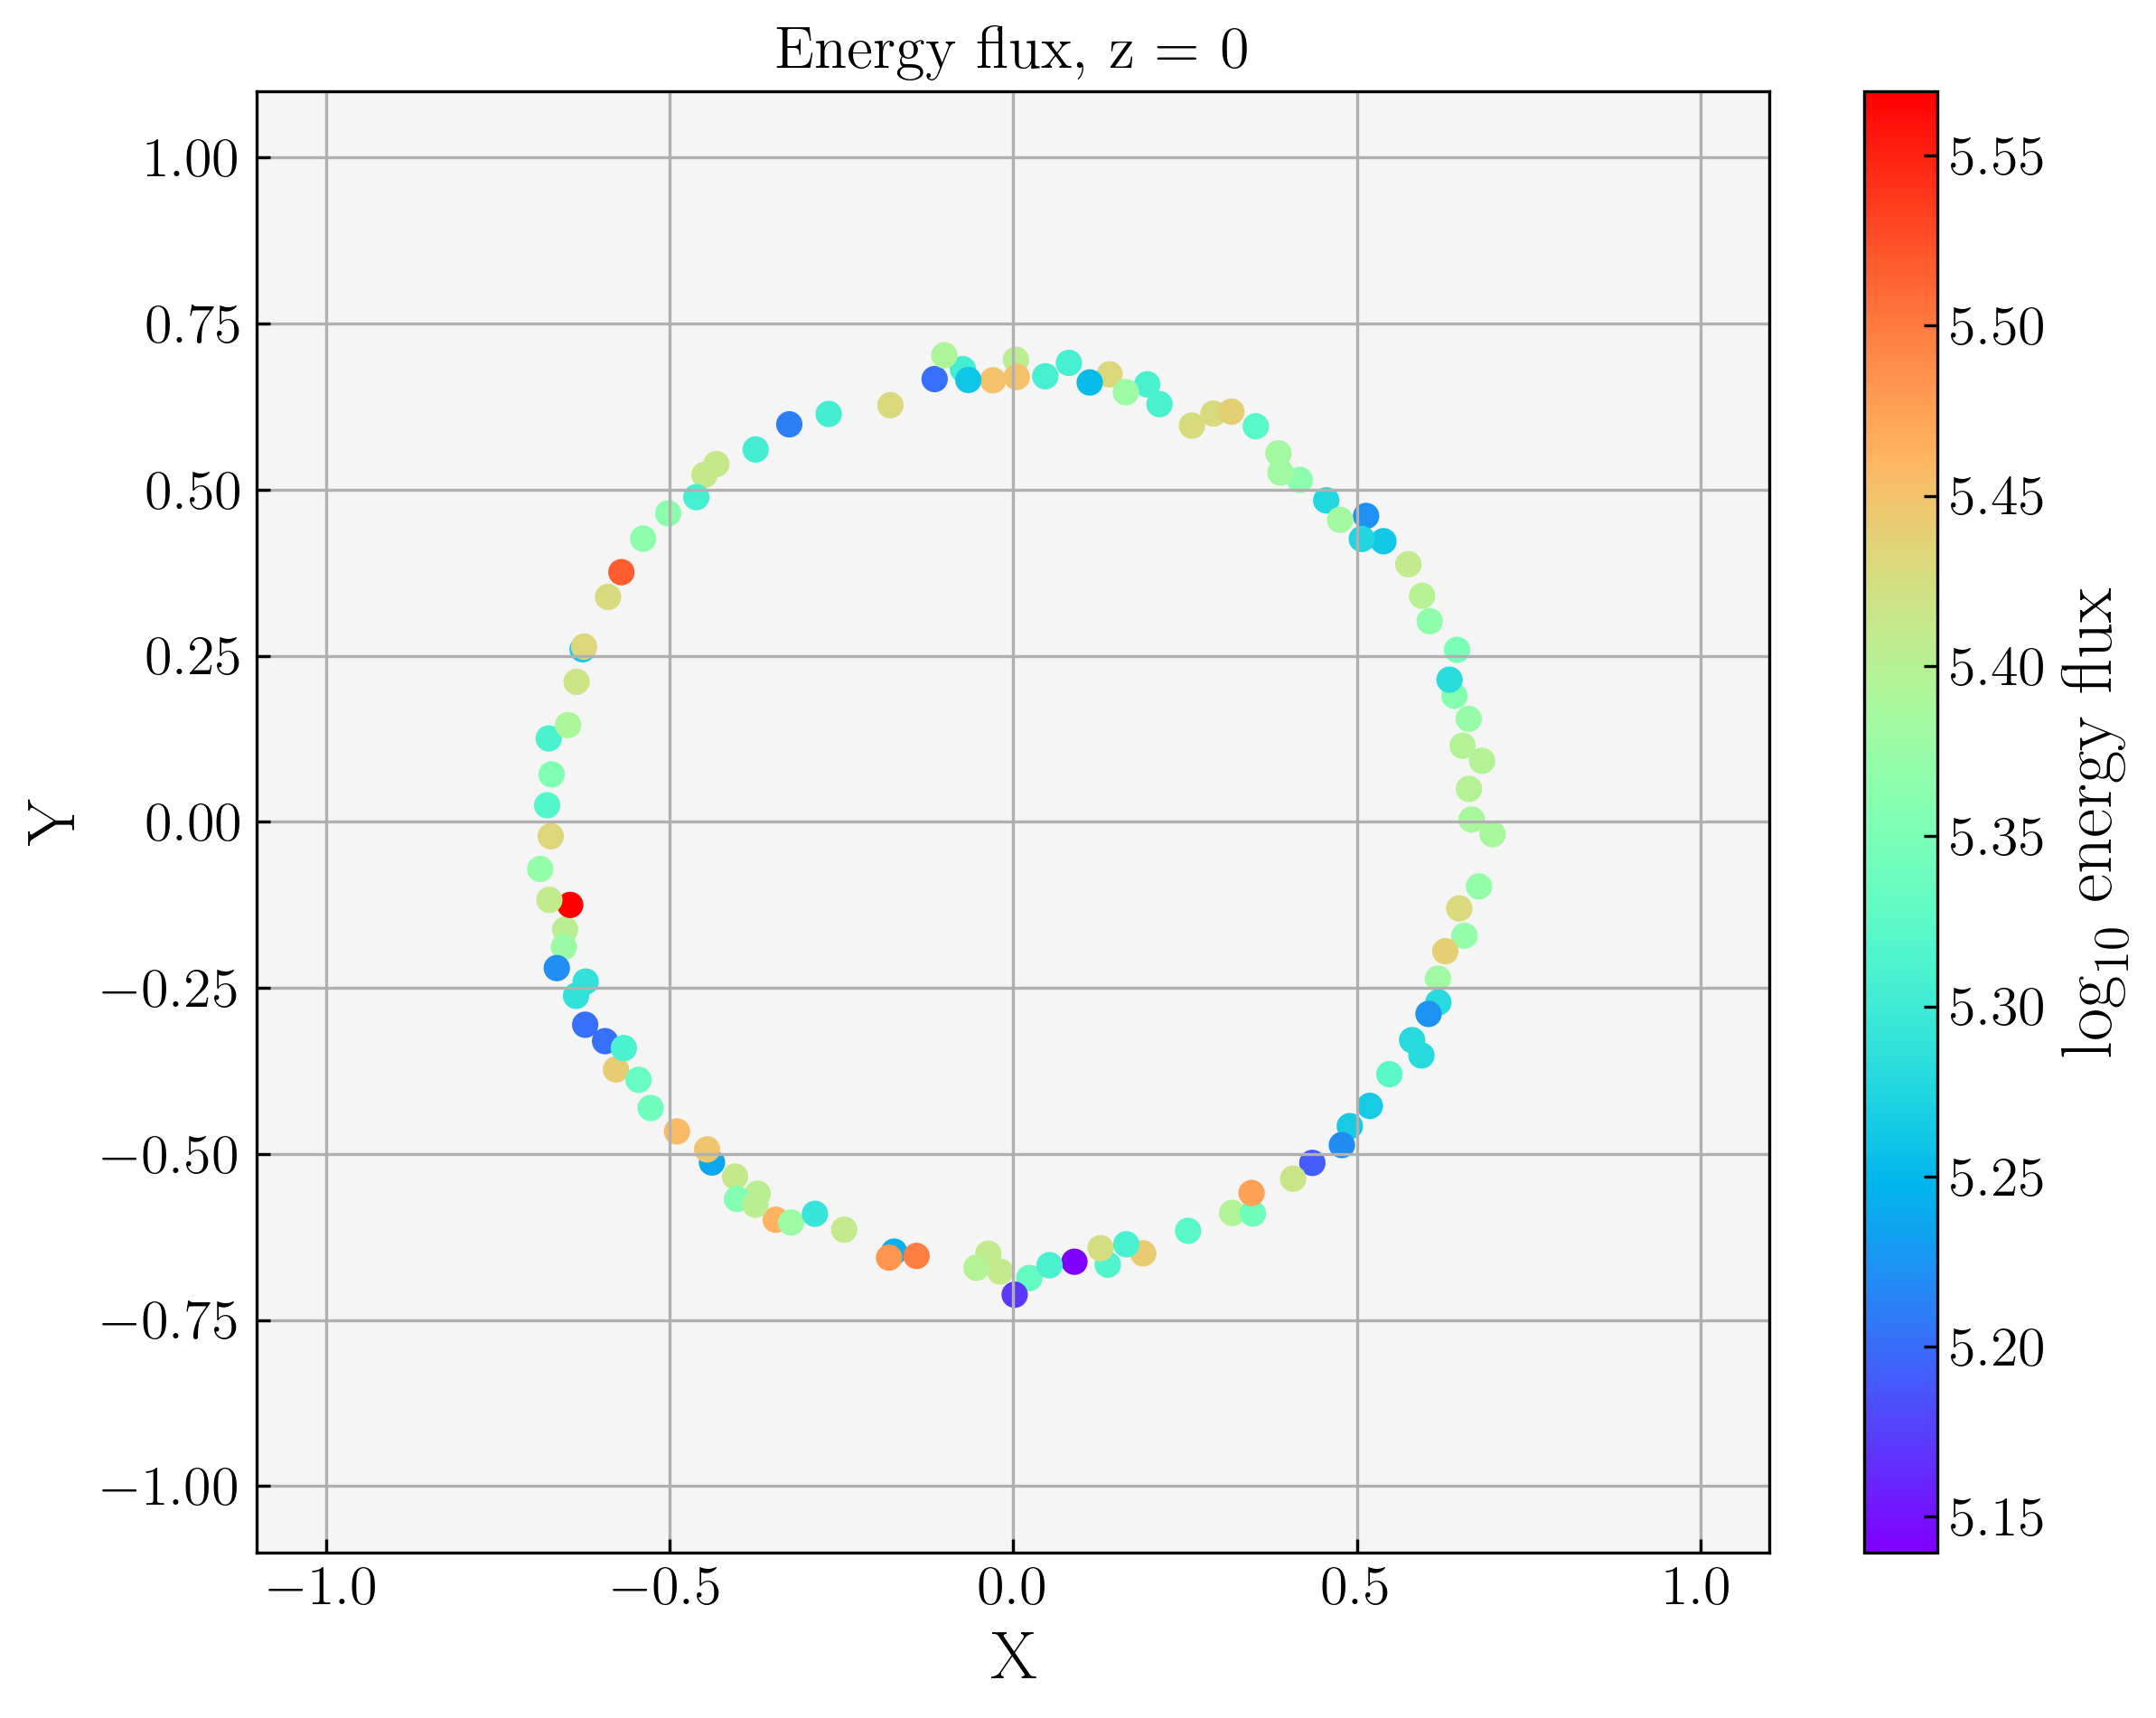

In [28]:
fig, ax = plt.subplots(1,1, figsize = (9,7))
img = ax.scatter(surface_cross_x, surface_cross_y, c = np.log10(flux_cross), cmap = 'rainbow')
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ energy flux', fontsize = 19)
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_xlabel('X', fontsize = 18)
ax.set_ylabel('Y', fontsize = 18)
plt.grid()
ax.set_title(f'Energy flux, z = {z_chosen}', fontsize = 16)
